<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

What is Autoencoders
</h1>
</div>

![](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_header.png)

Autoencoders is type of neual network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data.

In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=df941c70c412ef99e206625069efaabb105d90352da9baf01dd0198f09bbfb70
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Libraries
</h1>
</div>

In [2]:
import os
import glob
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Image Dir settings
</h1>
</div>

In [3]:
image_dir="../input/brain-mri-images-for-brain-tumor-detection/"

In [4]:
image_dir

'../input/brain-mri-images-for-brain-tumor-detection/'

(218, 180)


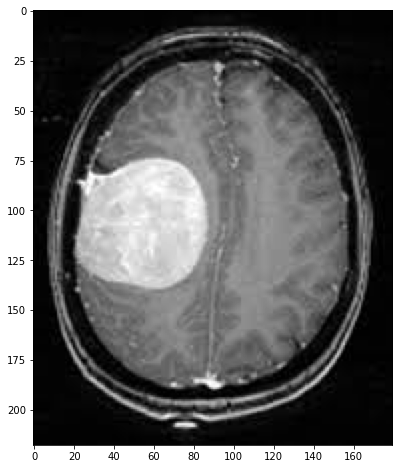

In [5]:
plt.figure(figsize=(20,8))
img = cv2.imread('../input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [6]:
Yes_IMAGES = glob.glob('../input/brain-mri-images-for-brain-tumor-detection/yes/*.jpg')
No_IMAGES = glob.glob('../input/brain-mri-images-for-brain-tumor-detection/no/*.jpg')

In [7]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Dataset Spliting
</h1>
</div>

In [8]:
x_train = load_image(Yes_IMAGES)
y_train = load_image(Yes_IMAGES)
x_test = load_image(No_IMAGES)

print(x_train.shape, x_test.shape)

(86, 258, 540, 1) (85, 258, 540, 1)


In [9]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(68, 258, 540, 1) (18, 258, 540, 1)


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Creating Autoencoder Class
</h1>
</div>

In [10]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Model Training
</h1>
</div>

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 258, 540, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
__________________________________________________

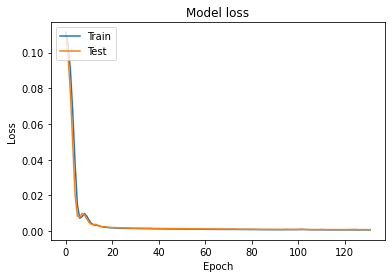

In [11]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=200, batch_size=20)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Predictions
</h1>
</div>

In [12]:
preds = ae.eval_model(x_test)

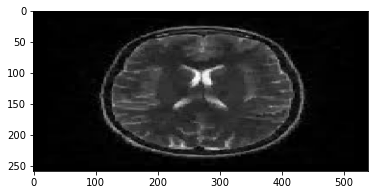

In [13]:
preds_0 = preds[10] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[10] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

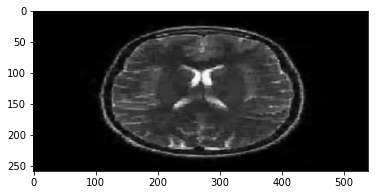

In [14]:
plt.imshow(preds_0, cmap='gray')

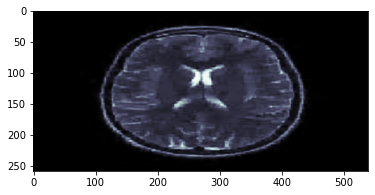

In [15]:
plt.imshow(preds_0, cmap='bone')

In [16]:
preds = preds.reshape(-1, 258, 540)

In [17]:
preds

array([[[0.09069397, 0.03506715, 0.02821123, ..., 0.02566133,
         0.02829228, 0.08130608],
        [0.03751336, 0.00990825, 0.00788413, ..., 0.00682419,
         0.00704147, 0.03309495],
        [0.03726853, 0.01094002, 0.00912587, ..., 0.00791223,
         0.00743751, 0.03178434],
        ...,
        [0.03446856, 0.00944379, 0.00754941, ..., 0.00709102,
         0.00696566, 0.03043204],
        [0.03699959, 0.00977884, 0.00768107, ..., 0.00727076,
         0.00755791, 0.03388574],
        [0.10649522, 0.04391977, 0.03665113, ..., 0.03575576,
         0.03852142, 0.10713651]],

       [[0.07975426, 0.02775116, 0.02099623, ..., 0.02033046,
         0.02336276, 0.07345721],
        [0.02974021, 0.00651633, 0.00468504, ..., 0.00445086,
         0.00493008, 0.02716949],
        [0.02824112, 0.00662   , 0.00491441, ..., 0.00460688,
         0.00470946, 0.0246151 ],
        ...,
        [0.0285075 , 0.00663514, 0.00488805, ..., 0.0044718 ,
         0.0046932 , 0.02449234],
        [0.0

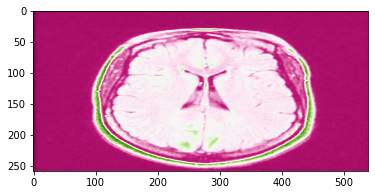

In [18]:
preds_1 = preds[20] * 255.0
preds_1 = preds_1.reshape(258, 540)

plt.imshow(preds_1, cmap='PiYG')

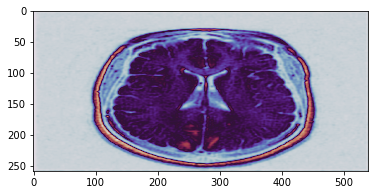

In [19]:
preds_2 = preds[50] * 255.0
preds_2 = preds_2.reshape(258, 540)

plt.imshow(preds_1, cmap='twilight')